<p style="text-align: center;font-size:25px;font-weight:700">Cookie Cats Mobile Game: A/B Testing</p> 

---

<p>Description from DataCamp: Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase.

In this project, I will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, I will analyze the impact on player retention and game rounds.

I worked with this data set in a DataCamp project [here](https://app.datacamp.com/learn/projects/184). However, instead of using the method demonstrated in the project, I want to use my own way to analyze the data for the purpose of learning. I am also curious to see if I will get different conclusion, so I found this data set on Kaggle.com. For more information, please follow the link [here](https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing?datasetId=272421). </p>

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/GaP5f0jVTWE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

<p style="text-align: center;font-size=20;font-weight:700">Notebook Content</p>
1. Import Libraries<br />
2. Exploratory Data Analysis<br />
&emsp; 2a. Import, clean, and validate data<br />
&emsp; 2b. Visualize data and explore relationships between variables<br />
&emsp; 2c. Calculate summary statistics<br />
3. A/B Testing<br />
&emsp; 3a. version vs sum_gamerounds<br />
&emsp; 3b. version vs retention_1<br />
&emsp; 3c. version vs retention_7<br />
4. Conclusion<br />

### 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import pingouin

### 2a. Import, clean, and validate data

In [3]:
df = pd.read_csv('C:\\Users\\34527\\Desktop\\cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
print(df.describe())
print('median  ', df['sum_gamerounds'].median())
print('---------------')
print(df.info())

             userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000
median   16.0
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


Looking at the description of the numeric value, we see that "userid", which is a number that uniquely identifies a player, is not in the correct format. Therefore, we will convert it to string later. Also, the numeric variable "sum_gamerounds" has a very large maximum value. I will check later to see if it tends to be a valid number or an outlier

In [5]:
df[(df.sum_gamerounds < np.percentile(df.sum_gamerounds, 25) - 1.5 * iqr(df.sum_gamerounds)) | \
   (df.sum_gamerounds > np.percentile(df.sum_gamerounds, 75) + 1.5 * iqr(df.sum_gamerounds))].shape

(10177, 5)

After getting the number of results outside of the IQR, we can see that there are quite some players who played very few or a low of rounds. Combining this with the description above, in which we see that mean is much larger than median, we know that the sum of game rounds played by player has a long tail on the right.

In [6]:
df.loc[df.sum_gamerounds < 49854, 'sum_gamerounds'].max()

2961

We can see that the second largest sum of game rounds played is 2,961. Since this is very different from 49,854, which occurred only once, we know that this number is likely invalid. Thus, we will remove before further analysis.

In [7]:
df_fixed = df[df.sum_gamerounds < 49854]
df_fixed['userid'] = df_fixed.userid.astype(str)

<ipython-input-7-6b598d21c7ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixed['userid'] = df_fixed.userid.astype(str)


### 2b. Visualize data and explore relationships between variables

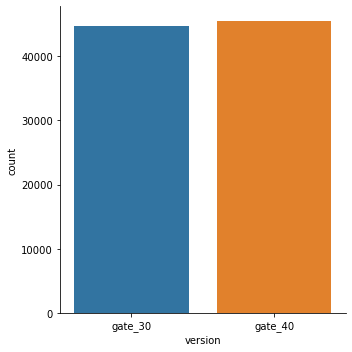

In [8]:
sns.catplot(x = 'version', data = df_fixed, kind = 'count')

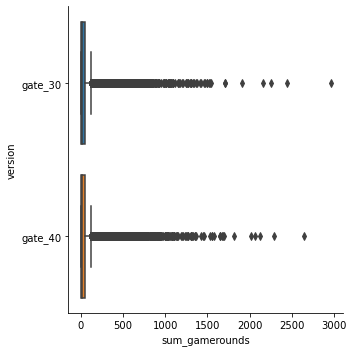

In [9]:
sns.catplot(x = 'sum_gamerounds', y = 'version', data = df_fixed, kind = 'box')

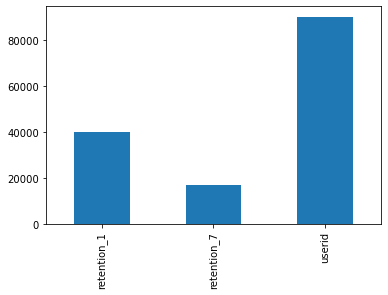

In [10]:
df_fixed[['retention_1', 'retention_7', 'userid']].agg({'retention_1':'sum', 'retention_7':'sum', 'userid':'count'}).plot(kind = 'bar')

### 2c. Calculate summary statistics

In [11]:
print(df_fixed[['userid']].apply(pd.Series.nunique))
print('-----')
print(df_fixed.shape[0])

userid    90188
dtype: int64
-----
90188


The count of unique userid is the same as the overall count of the userid. This means that no user is sampled twice, and the data is clean from that perspective.

In [12]:
df_fixed['version'].value_counts()

gate_40    45489
gate_30    44699
Name: version, dtype: int64

In [13]:
df_fixed[['retention_1', 'retention_7']].agg([sum, 'mean'])

,retention_1,retention_7
sum,40153.000000,16780.000000
mean,0.445214,0.186056


In [14]:
df_fixed.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].agg([sum, 'mean'])

sum_gamerounds            retention_1           retention_7          
                   sum       mean         sum      mean         sum      mean
version                                                                      
gate_30        2294941  51.342111     20034.0  0.448198      8501.0  0.190183
gate_40        2333530  51.298776     20119.0  0.442283      8279.0  0.182000

Looking at this table, we can see that the sum and mean of all three metrics under two versions are not too far from each other. We will conduct a hypothesis test to see if these differences are statistically significant.

### 3a. version vs sum_gamerounds

H0: placing the gate at level 30 results in the same sum of game rounds played on average than placing it at level 40<br />
H1: placing the gate at level 30 results in more sum of game rounds played on average than placing it at level 40

In [15]:
# Make 10000 bootstrap samples and calculate their mean of sum_gamerounds under the two version
boot_rounds = []
for i in range(10000):
    rounds_mean = df_fixed.sample(frac = 1, replace = True).groupby('version')['sum_gamerounds'].mean()
    boot_rounds.append(rounds_mean)
    
boot_rounds = pd.DataFrame(boot_rounds)
boot_rounds['diff'] = (boot_rounds.gate_30 - boot_rounds.gate_40) / boot_rounds.gate_40 * 100

C:\Users\34527\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


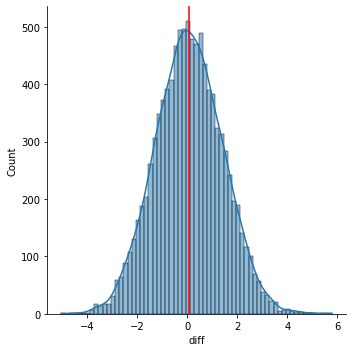

In [16]:
sns.displot(boot_rounds['diff'], kde = True)
plt.axvline(boot_rounds['diff'].mean(), color = 'red')

We can see that the mean of sum of game rounds played under the two version are similar, but the mean of the means falls a little to the right of the zero line. This means that placing the gate at level 30 results in a slightly more rounds played by the player on average

In [17]:
pingouin.ttest(x = boot_rounds.gate_30, y = boot_rounds.gate_40, alternative = 'greater', paired = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.153985,19998,greater,1.287169e-07,"[0.02, inf]",0.072888,1.836e+04,0.999775


After conducting a right-tailed t-test, we can see a p-value smaller than 0.05, which is a frequently used significance level. Thus, we have strong evidence to reject null hypothesis and conclude that placing the gate at level 30 results in more game rounds played on average

In [18]:
print(str(np.mean(boot_rounds.gate_30 > boot_rounds.gate_40) * 100) + '%')

51.970000000000006%


This number tells us that there in roughly a 53% chance that a player would play more if there gate is placed at level 30 vs level 40. This further supports the conclusion from our hypothesis test.

### 3b. version vs retention_1

H0: placing the gate at level 30 results in, on average, has no effect in making the players come back and play the game compared after one day of downlading the game with placing the gate at level 40<br />
H1: placing the gate at level 30 results in, on average, more players coming back and playing the game after one day of downlading the game compared with placing the gate at level 40

In [19]:
boot_retention1 = []
for i in range(10000):
    retention1_mean = df_fixed.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    boot_retention1.append(retention1_mean)
    
boot_retention1 = pd.DataFrame(boot_retention1)
boot_retention1['diff'] = (boot_retention1.gate_30 - boot_retention1.gate_40) / boot_retention1.gate_40 * 100

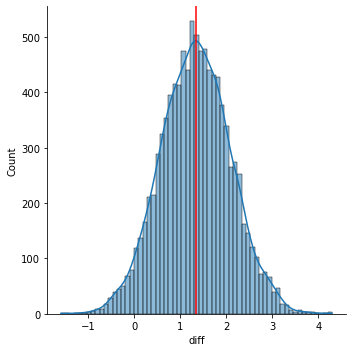

In [20]:
sns.displot(boot_retention1['diff'], kde = True)
plt.axvline(boot_retention1['diff'].mean(), color = 'red')

As the plot shows, the center of the distribution is on the right of the zero line for a significan distance. This means that a player who has the gate placed at level 30 is more likely to come back and play after one day of downloading the game, compared with placing the gate at level 40.

In [21]:
pingouin.ttest(x = boot_retention1.gate_30, y = boot_retention1.gate_40, alternative = 'greater', paired = False)

C:\Users\34527\AppData\Roaming\Python\Python38\site-packages\pingouin\bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,178.713796,19998,greater,0.0,"[0.01, inf]",2.527395,inf,1.0


In [22]:
print(str(np.mean(boot_retention1.gate_30 > boot_retention1.gate_40) * 100) + '%')

96.37%


Both the probability and the small p-value returned by the t-test give us strong evidence to reject the null hypothesis and conclude that placing the gate at level 30 results in more players coming back and playing after one day of downloading the game.

### 3c. version vs retention_7

H0: placing the gate at level 30 results in, on average, has no effect in making the players come back and play the game compared after seven day of downlading the game with placing the gate at level 40<br />
H1: placing the gate at level 30 results in, on average, more players coming back and playing the game after seven day of downlading the game compared with placing the gate at level 40

In [23]:
boot_retention7 = []
for i in range(10000):
    retention7_mean = df_fixed.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_retention7.append(retention7_mean)
    
boot_retention7 = pd.DataFrame(boot_retention7)
boot_retention7['diff'] = (boot_retention7.gate_30 - boot_retention7.gate_40) / boot_retention7.gate_40 * 100

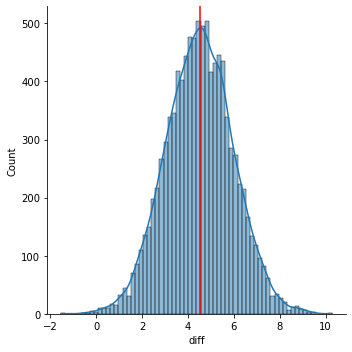

In [24]:
sns.displot(boot_retention7['diff'], kde = True)
plt.axvline(boot_retention7['diff'].mean(), color = 'red')

In [25]:
pingouin.ttest(x = boot_retention7.gate_30, y = boot_retention7.gate_40, alternative = 'greater', paired = False)

C:\Users\34527\AppData\Roaming\Python\Python38\site-packages\pingouin\bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,316.975281,19998,greater,0.0,"[0.01, inf]",4.482707,inf,1.0


In [26]:
print(str(np.mean(boot_retention7.gate_30 > boot_retention7.gate_40) * 100) + '%')

99.89%


Similar to 1-day retention, both the probability and the small p-value returned by the t-test give us strong evidence to reject the null hypothesis and conclude that placing the gate at level 30 results in more players coming back and playing after seven days of downloading the game.

### 4. conclusion

Based on what we saw from the three hypothesis tests, we have strong evidence to conclude that placing the gate at level 30 results in better metrics that we care about, including sum of game rounds played, retention in one day, and retention in seven day. Therefore, the company should not move the gate to level 40.